In [1]:
import torch
from torch import nn
from torch.nn import functional as f

In [2]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cuda'

In [3]:
class PatchEmbed(nn.Module):
    def __init__(self, img_size, patch_size, in_chans, embed_dim):
        super().__init__()

        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2

        self.proj = nn.Conv2d(
            in_chans,
            embed_dim, 
            kernel_size=patch_size,
            stride=patch_size
        )

    def forward(self,x):
        x = self.proj(x)
        x = x.flatten(2)
        x = x.transpose(1,2)
        return x

In [4]:
class Attention(nn.Module):
    def __init__(self, dim, n_heads=12, qkv_bias=True, attn_p=0., proj_p=0.):
        super().__init__()
        self.n_heads = n_heads
        self.dim = dim
        self.head_dim = dim // n_heads
        self.scale = self.head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_p)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_p)

    def forward(self, x):
        n_samples, n_tokens, dim = x.shape

        if dim != self.dim:
            raise ValueError

        qkv = self.qkv(x)  
        qkv = qkv.reshape(
                n_samples, n_tokens, 3, self.n_heads, self.head_dim
        )
        
        qkv = qkv.permute(2, 0, 3, 1, 4)  

        q, k, v = qkv[0], qkv[1], qkv[2]
        k_t = k.transpose(-2, -1)  
        
        dp = (q @ k_t) * self.scale 
        attn = dp.softmax(dim=-1)  
        attn = self.attn_drop(attn)

        weighted_avg = attn @ v  
        weighted_avg = weighted_avg.transpose(1, 2)  
        weighted_avg = weighted_avg.flatten(2)  

        x = self.proj(weighted_avg)  
        x = self.proj_drop(x)  

        return x

In [5]:
img_size = 224
patch_size = 16
in_chans = 3
embed_dim = 768

patch_embed = PatchEmbed(
    img_size=224,
    patch_size=16,
    in_chans=3,
    embed_dim=768
)

x = torch.randn(1, 3, 224, 224)

out = patch_embed(x)

print("Output shape:", out.shape)
assert out.shape == (1, 196, 768), "Output shape is incorrect!"

Output shape: torch.Size([1, 196, 768])


In [30]:
n_samples, n_tokens, dim = out.shape
n_samples, n_tokens, dim

(1, 196, 768)

In [31]:
qkv = nn.Linear(dim, dim * 3, bias=True)
qkv_out = qkv(out)
print("QKV output shape:", qkv_out.shape)

QKV output shape: torch.Size([1, 196, 2304])


In [35]:
qkv_reshaped = qkv_out.reshape(n_samples, n_tokens, 3, 12, dim//12)
print("QKV reshaped shape:", qkv_reshaped.shape)

QKV reshaped shape: torch.Size([1, 196, 3, 12, 64])


In [36]:
qkv_permuted = qkv_reshaped.permute(2, 0, 3, 1, 4)
print("QKV permuted shape:", qkv_permuted.shape)

QKV permuted shape: torch.Size([3, 1, 12, 196, 64])


In [37]:
q, k , v = qkv_permuted[0], qkv_permuted[1], qkv_permuted[2]
print("Q shape:", q.shape)
print("K shape:", k.shape)
print("V shape:", v.shape)

Q shape: torch.Size([1, 12, 196, 64])
K shape: torch.Size([1, 12, 196, 64])
V shape: torch.Size([1, 12, 196, 64])


In [38]:
k_t = k.transpose(-2, -1)
print("K transposed shape:", k_t.shape)

K transposed shape: torch.Size([1, 12, 64, 196])


In [39]:
dp = (q @ k_t) * (dim // 12) ** -0.5
print("Dot product shape:", dp.shape)

Dot product shape: torch.Size([1, 12, 196, 196])


In [40]:
attn = dp.softmax(dim=-1)
attn = nn.Dropout(0.1)(attn)
print("Attention shape:", attn.shape)

Attention shape: torch.Size([1, 12, 196, 196])


In [41]:
weghted_avg = attn @ v
weghted_avg = weghted_avg.transpose(1, 2)
print("Weighted average shape:", weghted_avg.shape)

weghted_avg = weghted_avg.flatten(2)
print("Weighted average flattened shape:", weghted_avg.shape)

Weighted average shape: torch.Size([1, 196, 12, 64])
Weighted average flattened shape: torch.Size([1, 196, 768])


In [43]:
weighted_proj = nn.Linear(dim, dim)(weghted_avg)
weighted_proj_dp = nn.Dropout(0.1)(weighted_proj)
print("Weighted projection shape:", weighted_proj_dp.shape)

Weighted projection shape: torch.Size([1, 196, 768])


In [6]:
class MLP(nn.Module):
    def __init__(self, in_features, hidden_features, out_features, p=0.0):
        super().__init__()
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(p)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

In [7]:
class Block(nn.Module):
    def __init__(self, dim, n_heads=12, mlp_ratio=4., qkv_bias=True, p=0.0, attn_p=0.0):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        
        self.attn = Attention(
            dim, 
            n_heads=n_heads, 
            qkv_bias=qkv_bias, 
            attn_p=attn_p,
            proj_p=p
        )
        
        self.norm2 = nn.LayerNorm(dim, eps=1e-6)
        
        mlp_hidden_dim = int(dim * mlp_ratio)
        
        self.mlp = MLP(dim, mlp_hidden_dim, dim, p=p)

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

In [8]:
class VIT(nn.Module):
    def __init__(
            self,
            img_size=384,
            patch_size=16,
            in_chans=3,
            n_classes=1000,
            embed_dim=768,
            depth=12,
            n_heads=12,
            mlp_ratio=4.,
            qkv_bias=True,
            p=0.0,
            attn_p=0.0
        ):

        super().__init__()
        self.patch_embed = PatchEmbed(
            img_size=img_size,
            patch_size=patch_size,
            in_chans=in_chans,
            embed_dim=embed_dim
        )

        self.cls_token = nn.Parameter(torch.zeros(1,1, embed_dim))
        self.pos_embed = nn.Parameter(
            torch.zeros(1, self.patch_embed.n_patches + 1, embed_dim)
        )
        self.pos_drop = nn.Dropout(p)

        self.blocks = nn.ModuleList([
            Block(
                dim=embed_dim,
                n_heads=n_heads,
                mlp_ratio=mlp_ratio,
                qkv_bias=qkv_bias,
                p=p,
                attn_p=attn_p
            ) for _ in range(depth)
        ])

        self.norm = nn.LayerNorm(embed_dim, eps=1e-6)
        self.head = nn.Linear(embed_dim, n_classes)

    def forward(self, x):
        n_samples = x.shape[0]
        x = self.patch_embed(x)
        cls_token = self.cls_token.expand(n_samples, -1, -1)
        x = torch.cat((cls_token, x), dim=1)
        x = x + self.pos_embed
        x = self.pos_drop(x)

        for block in self.blocks:
            x = block(x)

        x = self.norm(x)
        cls_token_final = x[:, 0]
        x = self.head(cls_token_final)
        return x

In [9]:
custom_config = {
    "img_size": 256,
    "patch_size": 16,
    "in_chans": 3,
    "n_classes": 257,
    "embed_dim": 384,
    "depth": 8,
    "n_heads": 6,
    "qkv_bias": True,
    "mlp_ratio": 4.0,
}

In [10]:
model = VIT(**custom_config).to(DEVICE)

In [11]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as T
import matplotlib.pyplot as plt
from torch.utils.data import random_split
from tqdm.auto import tqdm

In [12]:
transform = T.Compose([
    T.Resize((256, 256)),
    T.ToTensor(),
    T.ColorJitter(),
    T.RandomHorizontalFlip(),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [13]:
dataset = ImageFolder(root="./data/caltech256", transform=transform)

train_size = int(len(dataset)*0.8)
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [14]:
classes = dataset.classes
len(classes)

257

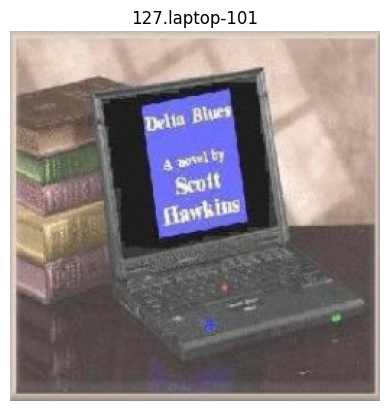

In [15]:
x, y = next(iter(train_dataloader))
plt.imshow(x[0].permute(1, 2, 0).numpy() * 0.5 + 0.5)
plt.title(classes[y[0]])
plt.axis("off")
plt.show()

In [16]:
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)
criterion = nn.CrossEntropyLoss()

In [25]:
LOAD=False
epochs_trained = 0

if LOAD:
    checkpoint = torch.load("model_2.pth")
    model.load_state_dict(checkpoint["model_weights"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    epochs_trained = checkpoint["epoch"]
    print("weigts loaded")
    
print(epochs_trained)

0


In [ ]:
from tqdm.notebook import tqdm

for epoch in range(11, 50):
    model.train()
    train_loss = 0.0
    train_acc = 0.0

    for x, y in tqdm(train_dataloader, desc=f"Epoch {epoch+1} [Train]"):
        x = x.to(DEVICE)
        y = y.to(DEVICE)

        
        output = model(x)
        loss = criterion(output, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * x.size(0)
        _, preds = torch.max(output, dim=1)
        train_acc += (preds == y).sum().item()

    train_loss /= len(train_dataloader.dataset)
    train_acc /= len(train_dataloader.dataset)
    tqdm.write(f"Epoch {epoch+1} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")

    # ----- Evaluation -----
    model.eval()
    test_loss = 0.0
    test_acc = 0.0

    with torch.no_grad():
        for x, y in tqdm(test_dataloader, desc=f"Epoch {epoch+1} [Eval]"):
            x = x.to(DEVICE)
            y = y.to(DEVICE)

            output = model(x)
            loss = criterion(output, y)

            test_loss += loss.item() * x.size(0)
            _, preds = torch.max(output, dim=1)
            test_acc += (preds == y).sum().item()

    test_loss /= len(test_dataloader.dataset)
    test_acc /= len(test_dataloader.dataset)
    tqdm.write(f"Epoch {epoch+1} - Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

    tqdm.write("--------------------------------------------------------------------------")


Epoch 12 [Train]:   0%|          | 0/766 [00:00<?, ?it/s]

Epoch 12 - Train Loss: 2.1983, Train Acc: 0.4722


Epoch 12 [Eval]:   0%|          | 0/192 [00:00<?, ?it/s]

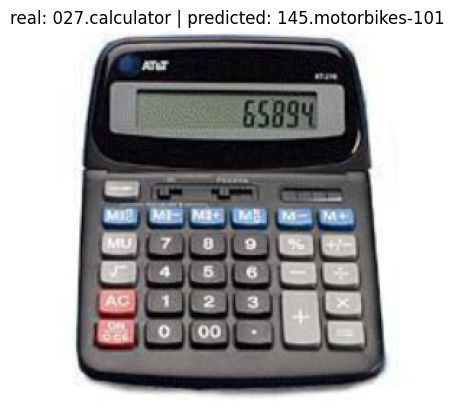

In [32]:
import random

test_image, cls = next(iter(test_dataloader))
model_pred = model(test_image.to(DEVICE))

no = random.randint(0, 31)
pred_label = model_pred[no].argmax().item()
true_label = cls[no].item()

plt.imshow(test_image[no].permute(1,2,0).detach().cpu().numpy() * 0.5 + 0.5)
plt.title(f"real: {classes[true_label]} | predicted: {classes[pred_label]}")
plt.axis("off")
plt.show()

In [33]:
checkpoint = {
    "optimizer" : optimizer.state_dict(),
    "model_weights": model.state_dict(),
    "epoch": epoch
}

torch.save(checkpoint, f"model_{epoch+1}.pth")